# Interpolation polynomial in the Lagrange form
Based on [this code](https://gist.github.com/folkertdev/084c53887c49a6248839)

$$f(x)\approx P_n(x)\,,$$

$$P_n(x) = \sum_{i=0}^n f(x_i)L_{n,i}(x) = \sum_{i=0}^n y_iL_{n,i}(x)$$

**References:**
[Wikipedia](https://en.wikipedia.org/wiki/Lagrange_polynomial)

### We will use SymPy

In [0]:
from sympy import simplify, symbols, expand, factor, sin, cos #..., lambdify, solve_poly_system

In [61]:
simplify('2/3+5/6')

3/2

In [62]:
x = symbols('x')
expand('(x-1)*(x+1)')

x**2 - 1

In [63]:
factor('x**2-1')

(x - 1)*(x + 1)

In [0]:
x=symbols('x')

##  Implementation of the Lagrange interpolating polynomials and  Lagrange polynomials in SymPy

In [65]:
%%writefile LagrangePolynomial.py
"""
From: https://gist.github.com/folkertdev/084c53887c49a6248839
A sympy-based Lagrange polynomial constructor. 

Implementation of Lagrangian interpolating polynomial.
See:

   def lagrangePolynomial(xs, ys):

Given two 1-D arrays `xs` and `ys,` returns the Lagrange interpolating
polynomial through the points ``(xs, ys)``


Given a set 1-D arrays of inputs and outputs, the lagrangePolynomial function 
will construct an expression that for every input gives the corresponding output. 
For intermediate values, the polynomial interpolates (giving varying results 
based  on the shape of your input). 

The Lagrangian polynomials can be obtained explicitly with (see below):
   
   def polyL(xs,j):
   
as sympy polynomial, and 

    def L(xs,j):

as Python functions.


This is useful when the result needs to be used outside of Python, because the 
expression can easily be copied. To convert the expression to a python function 
object, use sympy.lambdify.
"""
from sympy import symbols, expand, lambdify, solve_poly_system
#Python library for arithmetic with arbitrary precision
from mpmath import tan, e

import math

from operator import mul
from functools import reduce, lru_cache
from itertools import chain

# sympy symbols
x = symbols('x')

# convenience functions
product = lambda *args: reduce(mul, *(list(args) + [1]))

# test data
labels = [(-3/2), (-3/4), 0, 3/4, 3/2]
points = [math.tan(v) for v in labels]

# this product may be reusable (when creating many functions on the same domain)
# therefore, cache the result
@lru_cache(16)
def l(labels, j):
    def gen(labels, j):
        k = len(labels)
        current = labels[j]
        for m in labels:
            if m == current:
                continue
            yield (x - m) / (current - m)
    return expand(product(gen(labels, j)))

def polyL(xs,j):
    '''
    Lagrange polynomials as sympy polynomial
    xs: the n+1 nodes of the intepolation polynomial in the Lagrange Form
    j: Is the j-th Lagrange polinomial for the specific xs.
    '''
    xs=tuple(xs)
    return l(xs,j)

def L(xs,j):
    '''
    Lagrange polynomials as python function
    xs: the n+1 nodes of the intepolation polynomial in the Lagrange Form
    j: Is the j-th Lagrange polinomial for the specific xs.
    '''
    return lambdify(x, polyL(xs,j) )

def lagrangePolynomial(xs, ys):
    '''
    Given two 1-D arrays `x` and `w,` returns the Lagrange interpolating
    polynomial through the points ``(x, w)``.

    '''
    # based on https://en.wikipedia.org/wiki/Lagrange_polynomial#Example_1
    k = len(xs)
    total = 0

    # use tuple, needs to be hashable to cache
    xs = tuple(xs)

    for j, current in enumerate(ys):
        t = current * l(xs, j)
        total += t

    return total




def x_intersections(function, *args):
    "Finds all x for which function(x) = 0"
    # solve_poly_system seems more efficient than solve for larger expressions
    return [var for var in chain.from_iterable(solve_poly_system([function], *args)) if (var.is_real)]

def x_scale(function, factor):
    "Scale function on the x-axis"
    return functions.subs(x, x / factor)

if __name__ == '__main__':
    func = lagrangePolynomial(labels, points)

    pyfunc = lambdify(x, func)

    for a, b in zip(labels, points):
        assert(pyfunc(a) - b < 1e-6)

Overwriting LagrangePolynomial.py


In [66]:
%pylab inline
import pandas as pd
import numpy as np
import LagrangePolynomial as LP
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sin', 'cos']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Example of interpolation of tree points with a polynomial of degree 2

In [67]:
df=pd.DataFrame({ 'X':[3,10,21.3],'Y':[8.,6.5,3.]}  )
df

,X,Y
0,3.0,8.0
1,10.0,6.5
2,21.3,3.0


### `Numpy` implementation:

           2
-0.005216 x - 0.1465 x + 8.486


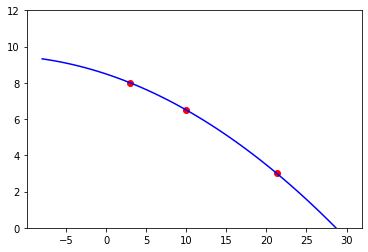

In [68]:
coeffs=np.polyfit(df.X,df.Y,deg=2)

P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
#plt.grid()
plt.ylim(0,12)

print(np.poly1d(coeffs))

### `Scipy` implementation of the Interpolation polynomial in the Lagrange form

In [0]:
interpolate.lagrange?

In [70]:
P=interpolate.lagrange(df.X,df.Y)
print(P)

           2
-0.005216 x - 0.1465 x + 8.486


### `Sympy` implementation of the Interpolation polynomial in the Lagrange form

In [71]:
LP.lagrangePolynomial(df.X,df.Y)

-0.00521578136549848*x**2 - 0.146480556534234*x + 8.48638370189219

With this simpy implementation we can check expliclty that:
$$P_2(x) =  L_{2,0}(x)f(x_0)+L_{2,1}(x)f(x_1)+L_{2,2}(x)f(x_2)$$

a) By using `sympy` polynomials:  `LP.polyL`:

In [72]:
LP.polyL( df.X,0)*df.Y[0]+LP.polyL( df.X,1)*df.Y[1]+LP.polyL( df.X,2)*df.Y[2]

-0.00521578136549848*x**2 - 0.146480556534234*x + 8.48638370189219

In [73]:
LP.polyL( df.X,0)

0.0078064012490242*x**2 - 0.244340359094457*x + 1.66276346604215

As a function

In [0]:
def P_2(x,xs,ys):
    return LP.L(xs,0)(x)*ys[0]+LP.L(xs,1)(x)*ys[1]+LP.L( xs,2)(x)*ys[2]

(0.0, 12.0)

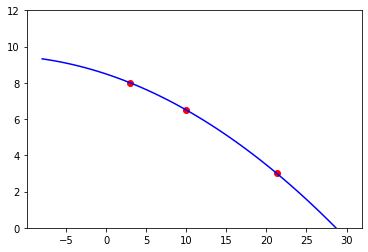

In [75]:
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P_2( x,df.X,df.Y),'b-')
#plt.grid()
plt.ylim(0,12)

## Lagrange polynomial properties
$$L_{n,i}(x_i) = 1\,,\qquad\text{and}\,,\qquad L_{n,i}(x_j) = 0\quad\text{for $i\neq j$}$$ 

As `sympy` objects

In [76]:
L2_0=LP.polyL(df.X,0)
L2_0

0.0078064012490242*x**2 - 0.244340359094457*x + 1.66276346604215

In [77]:
L2_0.as_poly()(df.X[0])

1.00000000000000

In [78]:
L2_0.as_poly()(df.X[1])

-4.44089209850063e-16

As `python` function

In [79]:
print( LP.L(df.X,0)(df.X[0]),LP.L(df.X,1)(df.X[1]),LP.L(df.X,2)(df.X[2]) )

0.9999999999999969 0.9999999999999951 0.9999999999999996


In [80]:
LP.L(df.X,0)(df.X)

0    1.000000e+00
1   -4.440892e-16
2    5.329071e-15
Name: X, dtype: float64

In [81]:
LP.L(df.X,1)(df.X)

0   -4.302114e-16
1    1.000000e+00
2   -2.042810e-14
Name: X, dtype: float64

In [82]:
LP.L(df.X,2)(df.X)

0    1.665335e-16
1    0.000000e+00
2    1.000000e+00
Name: X, dtype: float64

__Actividad__ Fit a cuatro puntos, comprobando las propiedades del ploinomio de Lagrange

In [83]:
# Se definen los 4 puntos como un data frame.

df4 = pd.DataFrame({'x': [3.3, 7.7, 9.1, 9.9],
                    'y': [-2.4, 4.2, -6.5, 8.6]})
df4

,x,y
0,3.3,-2.4
1,7.7,4.2
2,9.1,-6.5
3,9.9,8.6


In [84]:
# Fit utilizando función LP.

LP.lagrangePolynomial(df4.x, df4.y)

2.06514031945066*x**3 - 43.0856751007613*x**2 + 278.035662972085*x - 524.929633620689

In [85]:
# Base polinómica de Lagrange x0.

L0 = LP.polyL(df4.x, 0) # Generando polinomio.
print(L0)
L0_0 = L0.as_poly()(df4.x[0]) # Evaluando en x0.
print(L0_0)

-0.00593711408758431*x**3 + 0.158520946138501*x**2 - 1.40347439916405*x + 4.11853448275862
1.00000000000000


In [86]:
# Base polinómica de Lagrange x1.

L1 = LP.polyL(df4.x, 1) # Generando polinomio.
print(L1)
L1_1 = L1.as_poly()(df4.x[1]) # Evaluando en x1.
print(L1_1)

0.0737898465171193*x**3 - 1.64551357733176*x**2 + 11.2743506493507*x - 21.9375
1.00000000000002


In [87]:
# Base polinómica de Lagrange x2.

L2 = LP.polyL(df4.x, 2) # Generando polinomio.
print(L2)
L2_2 = L2.as_poly()(df4.x[2]) # Evaluando en x2.
print(L2_2)

-0.153940886699507*x**3 + 3.2173645320197*x**2 - 20.6758004926108*x + 38.7252155172414
1.00000000000002


In [88]:
# Base polinómica de Lagrange x3.

L3 = LP.polyL(df4.x, 3) # Generando polinomio.
print(L3)
L3_3 = L3.as_poly()(df4.x[3]) # Evaluando en x3.
print(L3_3)

0.0860881542699724*x**3 - 1.73037190082644*x**2 + 10.8049242424242*x - 19.90625
1.00000000000000


In [89]:
# Comprobando la interpolación mediante polyfit de numpy.

coef = np.polyfit(df4.x, df4.y, 3)

P_polyfit = np.poly1d(coef)

print(P_polyfit)

       3         2
2.065 x - 43.09 x + 278 x - 524.9


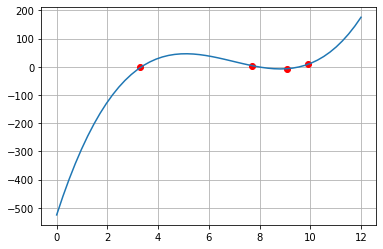

In [90]:
# Gráfica del polinomio encontrado con polyfit de numpy.

x = np.linspace(0, 12)

plt.plot(df4.x, df4.y, 'ro')
plt.plot(x, P_polyfit(x))
plt.grid()
plt.show()